In [1]:
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model
import os

In [2]:
from keras.preprocessing.image import ImageDataGenerator

In [3]:
img_width, img_height = 256, 256
batch_size = 32


train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.15
)


train_path = r"C:\Users\Siddhartha Devan V\Downloads\datasets\Tomato disease\train"

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_path,  # Path to the parent directory containing class folders
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  
    subset='training',
    classes = {'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 
               'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 
               'Tomato_mosaic_virus': 8,'powdery_mildew': 9, 'healthy': 10 }
)

Found 21974 images belonging to 11 classes.


In [5]:
valid_generator = train_datagen.flow_from_directory(
    train_path,  # Path to the parent directory containing class folders
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  
    subset='validation',
    classes = {'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 
               'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 
               'Tomato_mosaic_virus': 8,'powdery_mildew': 9, 'healthy': 10 }
)

Found 3871 images belonging to 11 classes.


In [6]:
print(train_generator.class_indices)

{'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'powdery_mildew': 9, 'healthy': 10}


In [7]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255
)


test_path = r"C:\Users\Siddhartha Devan V\Downloads\datasets\Tomato disease\valid"

In [8]:
test_generator = test_datagen.flow_from_directory(
    test_path,  # Path to the parent directory containing class folders
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  
    classes = {'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 
               'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 
               'Tomato_mosaic_virus': 8,'powdery_mildew': 9, 'healthy': 10 }
)

Found 6682 images belonging to 11 classes.


In [9]:
print(test_generator.class_indices)

{'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'powdery_mildew': 9, 'healthy': 10}


In [10]:
from architecture_module import QuadDense, ResidualBlock, InceptionBlock

In [11]:
class InceptionResidualNetwork(Model):
    def __init__(self, num_classes=2):
        super(InceptionResidualNetwork, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(kernel_size=(3,3), filters = 32)
        self.activation = tf.keras.layers.Activation('relu')
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(3,3))
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(kernel_size=(5,5), filters=64)
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(3,3))
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.inception_block_1 = InceptionBlock(n_filters=64)

        self.conv3 = tf.keras.layers.Conv2D(kernel_size=(3,3), filters = 128)
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=(3,3))
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.residual_1 = ResidualBlock(n_filters=64, kernel_size=(3,3))

        self.flatten = tf.keras.layers.Flatten()
        
        self.quad_dense1 = QuadDense(units=500, activation = 'relu')
        self.dense2 = tf.keras.layers.Dense(100, activation='relu')
        self.dense3 = tf.keras.layers.Dense(num_classes, activation='softmax')

    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.activation(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.activation(x)
        x = self.bn2(x)
        x = self.pool2(x)

        x = self.inception_block_1(x)

        x = self.conv3(x)
        x = self.activation(x)
        x = self.bn3(x)
        x = self.pool3(x)

        x = self.residual_1(x)

        x = self.flatten(x)

        x = self.quad_dense1(x)

        x = self.dense2(x)

        outputs = self.dense3(x)

        return outputs




In [12]:

model = InceptionResidualNetwork(num_classes=11)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
print(len(train_generator))

687


In [14]:
for _ in range(len(train_generator)):
    images, labels = train_generator.next()


In [15]:

history = model.fit(
    train_generator,  # Your generator object
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
)



Epoch 1/10
687/687 [==============================] - 171s 237ms/step - loss: 1.3264 - accuracy: 0.6153 - val_loss: 0.7510 - val_accuracy: 0.7295
Epoch 2/10
687/687 [==============================] - 120s 174ms/step - loss: 0.6772 - accuracy: 0.7659 - val_loss: 0.8887 - val_accuracy: 0.6921
Epoch 3/10
687/687 [==============================] - 118s 172ms/step - loss: 0.5268 - accuracy: 0.8181 - val_loss: 0.6862 - val_accuracy: 0.7812
Epoch 4/10
687/687 [==============================] - 121s 176ms/step - loss: 0.4206 - accuracy: 0.8521 - val_loss: 0.9799 - val_accuracy: 0.7605
Epoch 5/10
687/687 [==============================] - 231s 337ms/step - loss: 0.3474 - accuracy: 0.8820 - val_loss: 1.4638 - val_accuracy: 0.6324
Epoch 6/10
687/687 [==============================] - 347s 504ms/step - loss: 0.2756 - accuracy: 0.9065 - val_loss: 0.5110 - val_accuracy: 0.8548
Epoch 7/10
687/687 [==============================] - 332s 483ms/step - loss: 0.2320 - accuracy: 0.9228 - val_loss: 0.3129 -

In [16]:
model.save('model_1_without_aug_10_epochs_acc_95_val_87')

INFO:tensorflow:Assets written to: model_1_without_aug_10_epochs_acc_95_val_87\assets


INFO:tensorflow:Assets written to: model_1_without_aug_10_epochs_acc_95_val_87\assets


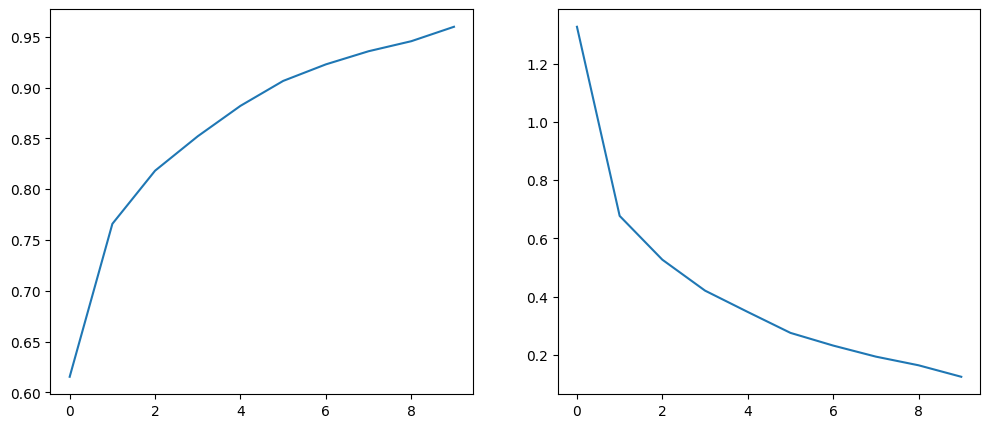

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

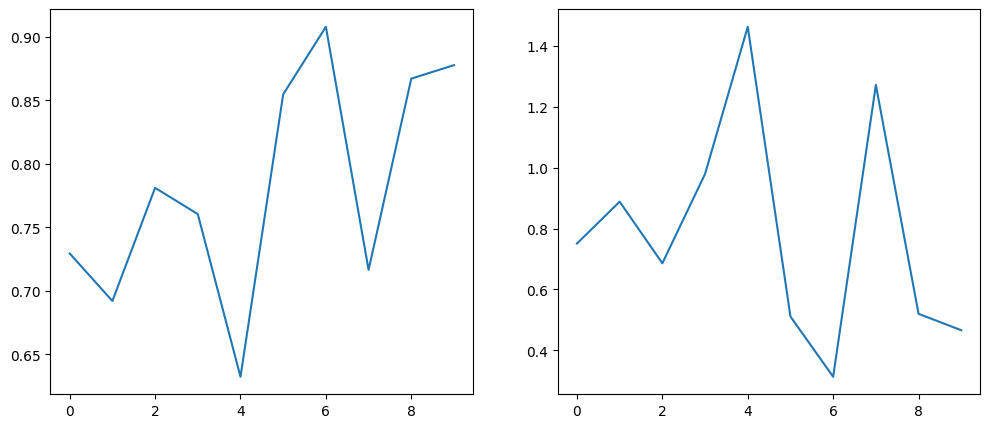

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'])
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'])

In [10]:
model = tf.keras.models.load_model('model_1_without_aug_10_epochs_acc_95_val_87')


In [46]:
import glob
traget_classes = test_generator.class_indices

img_paths = []
img_labels = []
tot_imgs = 0
for category in sorted(os.listdir(test_path)):
     target_dir = os.path.join(test_path, category)
     img_ps = os.listdir(target_dir)
     img_ps = [os.path.join(target_dir,img_ps[i]) for i in range(len(img_ps))]
     category_label = traget_classes[category]
     img_ls = [category_label for i in range(len(img_ps))]
     img_paths.append(img_ps)
     img_labels.append(img_ls)
     tot_imgs+=len(img_ps)
     print(len(img_ps), ' belonging to', category, category_label, 'found')

print(tot_imgs)

731  belonging to Bacterial_spot 0 found
643  belonging to Early_blight 1 found
792  belonging to Late_blight 2 found
739  belonging to Leaf_Mold 3 found
746  belonging to Septoria_leaf_spot 4 found
435  belonging to Spider_mites Two-spotted_spider_mite 5 found
457  belonging to Target_Spot 6 found
498  belonging to Tomato_Yellow_Leaf_Curl_Virus 7 found
584  belonging to Tomato_mosaic_virus 8 found
805  belonging to healthy 10 found
252  belonging to powdery_mildew 9 found
6682


In [47]:
all_imgs = []
all_labels = []

for i,j in zip(img_paths, img_labels):
    try:
        for path, label in zip(i, j):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            resized_img = cv2.resize(img, (256,256))
        
            all_imgs.append(resized_img)
            all_labels.append(label)
    except:
        print(path)
    print(j, 'done')


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [11]:

model.evaluate(test_generator)


209/209 [==============================] - 44s 164ms/step - loss: 0.5029 - accuracy: 0.8702


[0.5028994083404541, 0.8702484369277954]

In [22]:
for _ in range(len(test_generator)):
    try:
        images, labels = test_generator.next()
    except Exception as e:
        print(f"Error: {e}")

Error: image file is truncated


In [25]:
error_list = []
for _ in range(len(test_generator)):
    try:
        # Fetch the next batch of images and labels
        images, labels = test_generator.next()
    except Exception as e:
        # Get the current batch index
        current_batch_index = test_generator.batch_index
        
        # Calculate the start and end indices of the current batch in the list of filenames
        start_index = current_batch_index * test_generator.batch_size
        end_index = start_index + test_generator.batch_size
        
        # Print the error and the paths of the images causing the issue
        print(f"Error: {e}")
        print("File(s) causing the issue:")

        for filename in test_generator.filenames[start_index:end_index]:
            print(filename)
            error_list.append(filename)


Error: image file is truncated
File(s) causing the issue:
Early_blight\early-blight-tomatoes-potatoes.jpg
Early_blight\early-blight3-Gerald-Holmes-California-Polytechnic-State-University-at-San-Luis-Obispo-Bugwood.org_-1024x694.jpg
Early_blight\eb84cf99-aee8-4acc-8d3d-c5a24c672eb4___RS_Erly.B 7423_180deg.JPG
Early_blight\eb84cf99-aee8-4acc-8d3d-c5a24c672eb4___RS_Erly.B 7423_flipTB.JPG
Early_blight\eb94014e-83b7-46a4-9b1a-7cae23876302___RS_Erly.B 7471_flipTB.JPG
Early_blight\ebleafb_jpg.rf.453a4e4dacd018594e0f58ab14728e53.jpg
Early_blight\ed68595a-4d05-413c-a173-fa32cc8aae38___RS_Erly.B 7635.JPG
Early_blight\ee69b7e2-34d6-455f-97f6-6f5c06216131___RS_Erly.B 7478.JPG
Early_blight\eea79799-a869-4a1f-bfa2-5c85a27716ae___RS_Erly.B 8391_flipTB.JPG
Early_blight\eefcdf5d-5207-47ca-916d-0479f010bae8___RS_Erly.B 9482_180deg.JPG
Early_blight\ef68398c-ec92-4e44-961a-5ec1a29d3c28___RS_Erly.B 9620.JPG
Early_blight\ef7a2893-ca76-4f77-beb4-5bfcc729e324___RS_Erly.B 7454_flipTB.JPG
Early_blight\f035e3c9-

In [21]:

for i in error_list:
    
    with open(os.path.join(test_path, i), 'rb') as file:
        data = file.read()
    

In [18]:
print(error_list)

['healthy\\c5708e70-747e-44d9-ab7f-356157bfe0ec___RS_HL 9813.JPG', 'healthy\\c5db6d9e-4821-4b05-8b44-80ba702a8401___GH_HL Leaf 373.JPG', 'healthy\\c5f1eec0-35c2-43ce-8a14-575d86258f73___RS_HL 0337.JPG', 'healthy\\c7db2891-1bfa-4047-8864-66be6cc9e185___RS_HL 0162.JPG', 'healthy\\c7f91fa4-3769-45ef-a494-1669ee62ee7a___RS_HL 9812.JPG', 'healthy\\c8c7cb85-d7eb-4d60-b90e-bfe5277b79ad___GH_HL Leaf 277.JPG', 'healthy\\ca553e23-a738-485a-95e6-3b578477d3f4___RS_HL 9854.JPG', 'healthy\\ca6ad351-41f5-4893-8188-1c1c4b4184b4___GH_HL Leaf 496.4.JPG', 'healthy\\cb262ab1-f96f-4ade-80e9-d7fa2d5f9c9d___RS_HL 0361.JPG', 'healthy\\cb602835-7f6d-4926-80b4-77fe22f7ff66___GH_HL Leaf 226.JPG', 'healthy\\cdfe9df9-c3de-4660-8543-13911f281e47___RS_HL 0496.JPG', 'healthy\\ce081d63-8710-460f-9f20-cc67ef62fa37___RS_HL 9685.JPG', 'healthy\\ce303601-b655-483c-9778-3cbd317606be___RS_HL 0163.JPG', 'healthy\\ce56d8ec-bfd5-4755-8010-c42658f8d597___RS_HL 0090.JPG', 'healthy\\ce9cef60-51af-4e89-bbe7-bf463d767e99___RS_HL 06

In [10]:
for _ in range(len(train_generator)):
    try:
        images, labels = train_generator.next()
    except Exception as e:
        print(f"Error: {e}")
        print(f"File causing the issue: {train_generator.filenames[train_generator.batch_index * train_generator.batch_size : (train_generator.batch_index + 1) * train_generator.batch_size]}")
        

Error: [Errno 2] No such file or directory: 'C:\\Users\\Siddhartha Devan V\\Downloads\\datasets\\Tomato disease\\train\\Early_blight\\tomato-blight-soil-treatment-early-tomato-blight-in-a-microcosm-lower-leaves-curl-up-and-die-bulls-eye-lesions-tomato-fungus-soil-treatment_jpg.rf.3bb4c49c252adbdf4e53c6a518f9f699.jpg'
File causing the issue: ['Bacterial_spot\\463b2ce4-28ac-416d-9a43-2e494e649fbf___GCREC_Bact.Sp 6146.JPG', 'Bacterial_spot\\46520eb0-dbd0-40c7-ba4f-37510a15af9e___GCREC_Bact.Sp 5558.JPG', 'Bacterial_spot\\46638af1-9027-42c5-a5c0-03d6b684f975___UF.GRC_BS_Lab Leaf 0217.JPG', 'Bacterial_spot\\4669d307-bfa9-42ce-9724-cbfd3b37eaa3___GCREC_Bact.Sp 3276.JPG', 'Bacterial_spot\\46c03e65-7398-4ecb-aca4-69c0edb3015b___GCREC_Bact.Sp 5724.JPG', 'Bacterial_spot\\46d649c2-01cc-4716-8907-10ca3036c255___UF.GRC_BS_Lab Leaf 8868.JPG', 'Bacterial_spot\\46ed6749-0f57-42af-b984-e99567d5cd61___GCREC_Bact.Sp 3818.JPG', 'Bacterial_spot\\4707268c-7dea-4327-9b13-a8da598c4356___GCREC_Bact.Sp 3643.JPG'

In [11]:


l = ['Bacterial_spot\\463b2ce4-28ac-416d-9a43-2e494e649fbf___GCREC_Bact.Sp 6146.JPG', 'Bacterial_spot\\46520eb0-dbd0-40c7-ba4f-37510a15af9e___GCREC_Bact.Sp 5558.JPG', 'Bacterial_spot\\46638af1-9027-42c5-a5c0-03d6b684f975___UF.GRC_BS_Lab Leaf 0217.JPG', 'Bacterial_spot\\4669d307-bfa9-42ce-9724-cbfd3b37eaa3___GCREC_Bact.Sp 3276.JPG', 'Bacterial_spot\\46c03e65-7398-4ecb-aca4-69c0edb3015b___GCREC_Bact.Sp 5724.JPG', 'Bacterial_spot\\46d649c2-01cc-4716-8907-10ca3036c255___UF.GRC_BS_Lab Leaf 8868.JPG', 'Bacterial_spot\\46ed6749-0f57-42af-b984-e99567d5cd61___GCREC_Bact.Sp 3818.JPG', 'Bacterial_spot\\4707268c-7dea-4327-9b13-a8da598c4356___GCREC_Bact.Sp 3643.JPG', 'Bacterial_spot\\470dc5c1-47be-4468-ab17-e378715807e2___GCREC_Bact.Sp 3697.JPG', 'Bacterial_spot\\4714aa2d-34f6-45d3-906d-dde05519464b___UF.GRC_BS_Lab Leaf 9265.JPG', 'Bacterial_spot\\471a3798-e544-4f38-b0dc-bd8ccafcdafc___GCREC_Bact.Sp 3607.JPG', 'Bacterial_spot\\475758ba-01a6-41f7-abe4-81f2fff399b4___UF.GRC_BS_Lab Leaf 9185.JPG', 'Bacterial_spot\\476d4ff7-197e-4721-9875-527342fc4647___GCREC_Bact.Sp 3467.JPG', 'Bacterial_spot\\47798da0-ff59-497e-a2bb-e169c9138a7e___GCREC_Bact.Sp 3120.JPG', 'Bacterial_spot\\47a3c2c9-1f3b-4d42-8857-cfc714042c2a___UF.GRC_BS_Lab Leaf 8631.JPG', 'Bacterial_spot\\47ad1c56-26d9-46b8-a7b0-473a56024129___GCREC_Bact.Sp 3856.JPG', 'Bacterial_spot\\47d90e2b-bd1b-4b84-94dd-9cdfa31ba15a___GCREC_Bact.Sp 3732.JPG', 'Bacterial_spot\\482ef065-ba2f-4492-b215-9a60138a0047___GCREC_Bact.Sp 3090.JPG', 'Bacterial_spot\\483801eb-a0b8-4675-a731-40d6204ecbae___GCREC_Bact.Sp 5777.JPG', 'Bacterial_spot\\484ce1a5-f249-43ed-afb7-9cd7c2173e29___GCREC_Bact.Sp 3596.JPG', 'Bacterial_spot\\4850260f-50f5-4f6a-a0ab-1b5b744bdd13___GCREC_Bact.Sp 3346.JPG', 'Bacterial_spot\\486af1e3-91b4-4d0c-ba01-4992f9ddddce___GCREC_Bact.Sp 5745.JPG', 'Bacterial_spot\\486eeb98-44bd-405b-9756-5e2e4fd95b90___GCREC_Bact.Sp 3451.JPG', 'Bacterial_spot\\48f82716-ca44-4303-87ed-1d0c812bab49___GCREC_Bact.Sp 6036.JPG', 'Bacterial_spot\\4913ff90-0ca7-43b5-a157-a8ab19e43f12___UF.GRC_BS_Lab Leaf 0537.JPG', 'Bacterial_spot\\4987b5ee-012c-4bcd-854d-7881a50757fd___GCREC_Bact.Sp 3209.JPG', 'Bacterial_spot\\4990878e-265e-4dad-98cf-ce60fb67035b___GCREC_Bact.Sp 3479.JPG', 'Bacterial_spot\\499ed0ff-447b-4f2b-9f9d-d733202b4fcf___GCREC_Bact.Sp 3407.JPG', 'Bacterial_spot\\49b9840f-d9f1-42cc-92ad-96bbbd8bf9b2___GCREC_Bact.Sp 6379.JPG', 'Bacterial_spot\\49bfc0c9-1a64-4a1b-8a52-50d0df72e140___GCREC_Bact.Sp 3817.JPG', 'Bacterial_spot\\49c04c82-89d6-480e-96a3-d74a14b717b3___GCREC_Bact.Sp 3274.JPG', 'Bacterial_spot\\49c34c1b-08a8-4bdd-a933-0eb4daff5f97___GCREC_Bact.Sp 3501.JPG']

In [14]:
l =  ['Late_blight\\8168a850-1360-49cf-8ecc-77730cc24ac5___RS_Late.B 4979.JPG', 'Late_blight\\8183f4e9-fa24-4e80-be93-42983b086b7d___GHLB2 Leaf 8782.JPG', 'Late_blight\\81b4d72b-4124-45d4-b96a-0ec13ca7f376___GHLB2 Leaf 8989.JPG', 'Late_blight\\81baeedf-b56b-49b4-a7ff-131083f12ba1___GHLB2 Leaf 8710.JPG', 'Late_blight\\81cb76c4-86f6-4af3-a11a-ad827fff857c___RS_Late.B 5074.JPG', 'Late_blight\\81dc45ec-9ce3-4887-90b5-b091276a9245___RS_Late.B 4957.JPG', 'Late_blight\\82090f30-20fa-4c5e-9bcc-9cfe7d64b56a___RS_Late.B 5395.JPG', 'Late_blight\\8217ab61-6b5f-4874-8046-d801d40cff3d___RS_Late.B 6089.JPG', 'Late_blight\\8224fe93-c0bc-47e1-8ef4-3572667de662___GHLB2 Leaf 8694.JPG', 'Late_blight\\8275c408-1ce2-4b4b-a6de-b7a0b373ad05___GHLB2 Leaf 8741.JPG', 'Late_blight\\82dc2c64-2489-49d7-b199-f8c6a04c1649___RS_Late.B 6282.JPG', 'Late_blight\\830c33b8-d419-4fb7-98f8-08387e726648___GHLB_PS Leaf 1.5 Day 16.jpg', 'Late_blight\\8342c931-3c80-48ce-9757-f497c36cf44e___RS_Late.B 6125.JPG', 'Late_blight\\835b856f-9f36-474c-b5e9-2961a7fb97c5___RS_Late.B 5187.JPG', 'Late_blight\\838c4952-8d91-44b9-905d-96b065683f21___RS_Late.B 6038.JPG', 'Late_blight\\83abc50b-0705-4165-a9f3-e67b7ad93bf0___RS_Late.B 6170.JPG', 'Late_blight\\843d28c8-6dc1-4048-94fc-8064ee8ff394___RS_Late.B 6746.JPG', 'Late_blight\\845735fd-cca2-4d7b-ace8-292ca8f5f940___GHLB2 Leaf 8771.JPG', 'Late_blight\\846005e7-d4ad-49e4-bfce-3aefe50b44e0___RS_Late.B 5158.JPG', 'Late_blight\\851d91ae-4a1f-448e-afdc-09a961345353___RS_Late.B 5466.JPG', 'Late_blight\\853e9c8a-d5b3-4fff-a9a3-f047812aa4a3___RS_Late.B 5240.JPG', 'Late_blight\\854f717b-5d27-4d21-be89-29bf935b069a___GHLB2 Leaf 8650.JPG', 'Late_blight\\8553094b-3e19-4e4c-8ba1-49e98ff135e9___RS_Late.B 4869.JPG', 'Late_blight\\85550b3b-28a6-4489-ae91-63ea771622ae___RS_Late.B 5539.JPG', 'Late_blight\\85a581dc-108b-4ca0-9f34-f8b2baeccbe6___GHLB2 Leaf 8788.JPG', 'Late_blight\\85d80245-6c80-4bb7-9497-c8612903b535___RS_Late.B 5576.JPG', 'Late_blight\\860b6c56-686a-4f21-8ae3-d7e45acd760b___GHLB_PS Leaf 25 Day 16.jpg', 'Late_blight\\861d8b00-57a4-46b0-b51a-09d102dbe119___GHLB_PS Leaf 24 Day 13.jpg', 'Late_blight\\8634f13d-ee5a-442e-8b58-6b667c91379c___GHLB2 Leaf 8968.JPG', 'Late_blight\\8662590c-1a1e-450e-97fa-07fb26faf0c1___GHLB2 Leaf 8919.JPG', 'Late_blight\\869168d7-a45c-40e6-888b-ad5ba94a657e___RS_Late.B 6193.JPG', 'Late_blight\\86992828-48ea-428c-bb7d-0c89365314b9___GHLB_PS Leaf 18.2 Day 8.jpg']

for i in l:
    print(i)
    

Late_blight\8168a850-1360-49cf-8ecc-77730cc24ac5___RS_Late.B 4979.JPG
Late_blight\8183f4e9-fa24-4e80-be93-42983b086b7d___GHLB2 Leaf 8782.JPG
Late_blight\81b4d72b-4124-45d4-b96a-0ec13ca7f376___GHLB2 Leaf 8989.JPG
Late_blight\81baeedf-b56b-49b4-a7ff-131083f12ba1___GHLB2 Leaf 8710.JPG
Late_blight\81cb76c4-86f6-4af3-a11a-ad827fff857c___RS_Late.B 5074.JPG
Late_blight\81dc45ec-9ce3-4887-90b5-b091276a9245___RS_Late.B 4957.JPG
Late_blight\82090f30-20fa-4c5e-9bcc-9cfe7d64b56a___RS_Late.B 5395.JPG
Late_blight\8217ab61-6b5f-4874-8046-d801d40cff3d___RS_Late.B 6089.JPG
Late_blight\8224fe93-c0bc-47e1-8ef4-3572667de662___GHLB2 Leaf 8694.JPG
Late_blight\8275c408-1ce2-4b4b-a6de-b7a0b373ad05___GHLB2 Leaf 8741.JPG
Late_blight\82dc2c64-2489-49d7-b199-f8c6a04c1649___RS_Late.B 6282.JPG
Late_blight\830c33b8-d419-4fb7-98f8-08387e726648___GHLB_PS Leaf 1.5 Day 16.jpg
Late_blight\8342c931-3c80-48ce-9757-f497c36cf44e___RS_Late.B 6125.JPG
Late_blight\835b856f-9f36-474c-b5e9-2961a7fb97c5___RS_Late.B 5187.JPG
Late_b

In [15]:
print(len(i))

78


In [28]:

for _ in range(len(train_generator)):
    try:
        images, labels = train_generator.next()
    except Exception as e:
        file_list = train_generator.filenames[train_generator.batch_index * train_generator.batch_size : (train_generator.batch_index + 1) * train_generator.batch_size]
        print(len(file_list), file_list)
        for file in file_list:
            try:
                img = cv2.imread(os.path.join(train_path, img))
                print(img[:1][:2])
            except Exception as ee:
                print()
                print(ee, file)


32 ['Leaf_Mold\\50e1906e-24da-493d-88b0-3110e778a26a___Crnl_L.Mold 7135_flipTB.JPG', 'Leaf_Mold\\50f3f827-c254-4de3-a7d3-0a5d755367fc___Crnl_L.Mold 8733_180deg.JPG', 'Leaf_Mold\\50f3f827-c254-4de3-a7d3-0a5d755367fc___Crnl_L.Mold 8733_flipTB.JPG', 'Leaf_Mold\\51189dab-468d-4304-8368-d0e4e3247194___Crnl_L.Mold 6667.JPG', 'Leaf_Mold\\51189dab-468d-4304-8368-d0e4e3247194___Crnl_L.Mold 6667_flipTB.JPG', 'Leaf_Mold\\519d366c-f967-452e-aaef-a9965368c310___Crnl_L.Mold 6952.JPG', 'Leaf_Mold\\519d366c-f967-452e-aaef-a9965368c310___Crnl_L.Mold 6952_180deg.JPG', 'Leaf_Mold\\51cb012e-4646-447c-b63f-9084a370b781___Crnl_L.Mold 6916.JPG', 'Leaf_Mold\\51cb012e-4646-447c-b63f-9084a370b781___Crnl_L.Mold 6916_flipTB.JPG', 'Leaf_Mold\\51cc89e4-4693-4470-9ddb-2fff4ab8da50___Crnl_L.Mold 8694.JPG', 'Leaf_Mold\\51cc89e4-4693-4470-9ddb-2fff4ab8da50___Crnl_L.Mold 8694_180deg.JPG', 'Leaf_Mold\\5232c7a2-7f94-4e6e-b47a-6264e1e49ff8___Crnl_L.Mold 7161_180deg.JPG', 'Leaf_Mold\\5232c7a2-7f94-4e6e-b47a-6264e1e49ff8___C

In [25]:
l = ['Bacterial_spot\\e14b7ae8-96ff-47e0-8b35-aa7203dc49d5___GCREC_Bact.Sp 3020.JPG', 'Bacterial_spot\\e16cf895-d49f-4798-af76-1343bdd0fe56___GCREC_Bact.Sp 3025.JPG', 'Bacterial_spot\\e17ce060-c563-4f08-ad38-e491d5f09688___GCREC_Bact.Sp 5661.JPG', 'Bacterial_spot\\e18a4fc4-f116-4eef-8cca-d62a2798ac8d___GCREC_Bact.Sp 3743.JPG', 'Bacterial_spot\\e19aa48d-2c0f-41ac-b6e4-d648371236f3___GCREC_Bact.Sp 5545.JPG', 'Bacterial_spot\\e1a293e6-03fa-4513-b45b-94fbe2d0b748___GCREC_Bact.Sp 3833.JPG', 'Bacterial_spot\\e1befb62-870e-400b-9ecb-167138652029___GCREC_Bact.Sp 5758.JPG', 'Bacterial_spot\\e1ee0df9-7ad3-47f4-ba57-0e243101a657___GCREC_Bact.Sp 3702.JPG', 'Bacterial_spot\\e1fa4f5f-d166-4483-95c4-0c420ee2098e___GCREC_Bact.Sp 3458.JPG', 'Bacterial_spot\\e2286f6d-1e30-4528-ab51-84c18a16b7e1___GCREC_Bact.Sp 3503.JPG', 'Bacterial_spot\\e25c59a0-9362-4218-82de-9060174d5473___GCREC_Bact.Sp 6277.JPG', 'Bacterial_spot\\e277b59d-2e55-4117-92c7-93996599ef02___GCREC_Bact.Sp 3168.JPG', 'Bacterial_spot\\e28b2c59-c08e-4957-975f-2965d8b801e2___GCREC_Bact.Sp 3321.JPG', 'Bacterial_spot\\e28da6e4-81ad-42ff-ad15-b7a60d9546f2___GCREC_Bact.Sp 6363.JPG', 'Bacterial_spot\\e2941eab-3c1c-43a2-aa6d-5f3926da0568___GCREC_Bact.Sp 3495.JPG', 'Bacterial_spot\\e2c2e02e-091d-46ef-a9a7-638dfd4decd6___GCREC_Bact.Sp 3228.JPG', 'Bacterial_spot\\e2c80b64-2520-49c4-bedc-a604355be09b___GCREC_Bact.Sp 3609.JPG', 'Bacterial_spot\\e2f66625-6241-4cd5-8302-c76cdd2e463c___GCREC_Bact.Sp 3761.JPG', 'Bacterial_spot\\e351d0c3-b7c6-4c94-9428-e350c4325a22___GCREC_Bact.Sp 3089.JPG', 'Bacterial_spot\\e39108c9-61e6-405a-bad1-84f0d1fbb25b___GCREC_Bact.Sp 5915.JPG', 'Bacterial_spot\\e4097ba1-9edf-4f41-9c11-6dee42bd56b4___GCREC_Bact.Sp 2999.JPG', 'Bacterial_spot\\e41ca477-b751-45f7-9a19-3442349e45ef___GCREC_Bact.Sp 3254.JPG', 'Bacterial_spot\\e4404de4-7958-4e77-a7ed-664dd0d7f2c9___GCREC_Bact.Sp 5906.JPG', 'Bacterial_spot\\e444a471-4021-424b-a375-78f3b17413c8___GCREC_Bact.Sp 6319.JPG', 'Bacterial_spot\\e45ae43b-3111-47af-8da4-65dc05595a7f___GCREC_Bact.Sp 5973.JPG', 'Bacterial_spot\\e48d7087-f125-4912-b9d6-65fdeedd2ddb___GCREC_Bact.Sp 6182.JPG', 'Bacterial_spot\\e4be767a-e84a-4fd6-9049-ed4ff05962ac___GCREC_Bact.Sp 3678.JPG', 'Bacterial_spot\\e4d01d54-df44-40ab-a6f9-74c9e0834998___GCREC_Bact.Sp 5950.JPG', 'Bacterial_spot\\e4dad7d3-b043-4dc9-9b41-0df12c1a6823___GCREC_Bact.Sp 5822.JPG', 'Bacterial_spot\\e4df0a0f-a7cf-4797-a888-9f28d916bccd___GCREC_Bact.Sp 5870.JPG', 'Bacterial_spot\\e4e11751-2c64-491f-9aa3-26677932f65c___UF.GRC_BS_Lab Leaf 0636.JPG', 'Bacterial_spot\\e4e708ea-e69e-4e5c-9e52-1f21407f7568___GCREC_Bact.Sp 3813.JPG']

for img in l:
    re = cv2.imread(os.path.join(train_path, img))
    

[[[109 108 118]
  [144 143 153]
  [129 128 138]
  [126 125 135]
  [112 111 121]
  [ 96  95 105]
  [ 80  79  89]
  [128 127 137]
  [104 103 113]
  [124 123 133]
  [122 121 131]
  [109 108 118]
  [120 119 129]
  [117 116 126]
  [106 105 115]
  [106 105 115]
  [100 101 111]
  [110 111 121]
  [ 83  84  94]
  [126 127 137]
  [112 113 123]
  [115 116 126]
  [ 99 100 110]
  [116 117 127]
  [ 99 100 110]
  [123 124 134]
  [101 102 112]
  [106 107 117]
  [119 120 130]
  [107 108 118]
  [110 111 121]
  [102 103 113]
  [117 117 129]
  [116 116 128]
  [105 105 117]
  [106 106 118]
  [129 129 141]
  [109 109 121]
  [127 127 139]
  [100 100 112]
  [110 110 122]
  [ 81  81  93]
  [108 108 120]
  [112 112 124]
  [ 98  98 110]
  [111 111 123]
  [111 111 123]
  [110 110 122]
  [ 94  94 106]
  [ 97  97 109]
  [108 108 120]
  [121 121 133]
  [121 121 133]
  [111 111 123]
  [103 103 115]
  [102 102 114]
  [106 106 118]
  [113 113 125]
  [ 97  97 109]
  [109 109 121]
  [114 114 126]
  [102 102 114]
  [103 1